# A Functional Information Perspective on Model Interpretation - DEMO

In [1]:
from fi_code.fi import *
from fi_code.utils import *
from fi_code.basic_models import *
from IPython.core.display import display, HTML
import os

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [3]:
?explain

In [4]:
?explain_batch

# Explaining CIFAR10 (Image Modality)

### Training ResNet

In [5]:
train_loader, test_loader, classes = prepare_cifar10_data_loaders()
model = ResNet.ResNet18().to(device)
model = model.train_model(train_loader, test_loader, epochs=10)

# saving the model
os.makedirs('models', exist_ok=True)
torch.save(model, 'models/resnet18_cifar10_model.pt')

Files already downloaded and verified
Files already downloaded and verified
Train - Loss: 1.425 | Acc: 0.475
Test - Loss: 1.079 | Acc: 0.609
Train - Loss: 0.940 | Acc: 0.667
Test - Loss: 0.857 | Acc: 0.708
Train - Loss: 0.724 | Acc: 0.746
Test - Loss: 0.729 | Acc: 0.750
Train - Loss: 0.593 | Acc: 0.793
Test - Loss: 0.604 | Acc: 0.799
Train - Loss: 0.503 | Acc: 0.825
Test - Loss: 0.558 | Acc: 0.817
Train - Loss: 0.439 | Acc: 0.847
Test - Loss: 0.478 | Acc: 0.839
Train - Loss: 0.377 | Acc: 0.870
Test - Loss: 0.434 | Acc: 0.854
Train - Loss: 0.328 | Acc: 0.887
Test - Loss: 0.424 | Acc: 0.858
Train - Loss: 0.292 | Acc: 0.900
Test - Loss: 0.396 | Acc: 0.867
Train - Loss: 0.271 | Acc: 0.907
Test - Loss: 0.379 | Acc: 0.872


### Loading the model, calculating the covariances

In [6]:
model = torch.load('models/resnet18_cifar10_model.pt').to(device)
# loading loaders again without transformations
train_loader, test_loader, classes = prepare_cifar10_data_loaders(training_transforms=False) 
labels_dict = {i: c for i, c in enumerate(classes)}
covariances, choleskies = calculate_image_covariances(train_loader, per_channel=True)

Files already downloaded and verified
Files already downloaded and verified


### Explanations

In [7]:
# preparing the inputs

indices = list(range(318, 328))
inputs, targets = get_indices(test_loader.dataset, indices)
imgs = list(denormalize_cifar10_images(inputs).detach().cpu().numpy())
inputs = list(inputs)
labels = targets.cpu().detach().tolist()
inputs_covs = [covariances[i] for i in labels]
inputs_chols = [choleskies[i] for i in labels]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


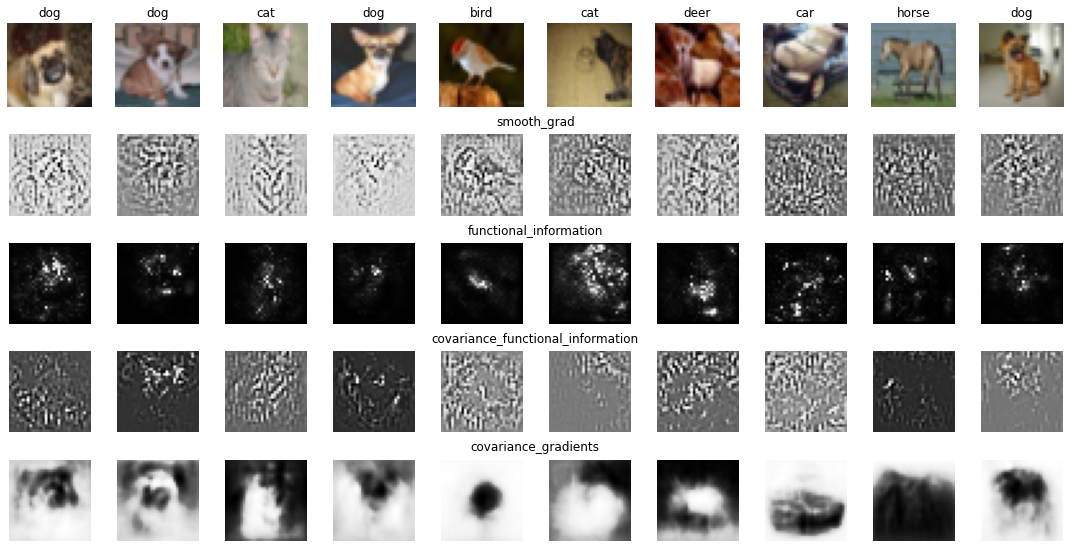

In [8]:
methods = ['smooth_grad', 'functional_information', 'covariance_functional_information', 'covariance_gradients']
activation = torch.nn.Softmax(dim=-1)
explanations = explain_batch(model, inputs, methods,
                             covariance=inputs_covs, cholesky_decomposed_covariance=inputs_chols,
                             modality='image', n=100, label=labels, pertubation_device='cpu',
                             outputs_activation_func=activation)

show_explanations_grid(imgs, explanations, [labels_dict[l] for l in labels])

# Explaining IMDB Reviews (Text Modality)

### Training BiLSTM

In [9]:
from transformers import AutoTokenizer

model_name = "distilbert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
train_dataloader, test_dataloader = prepare_imdb_data_loaders(tokenizer, with_cls=False)
model = LSTMClassifier.from_pretrained(pretrained_model_name_or_path=model_name,
                                       num_classes=2, bidirectional=True)
model = model.to(device)
model = model.train_model(train_dataloader, test_dataloader, n_epochs=2)

# saving the model
os.makedirs('models', exist_ok=True)
torch.save(model, 'models/lstm_imdb_model.pt')

Using custom data configuration default-data_dir=data%2Fimdb
Reusing dataset imdb (/home/nitay/.cache/huggingface/datasets/imdb/default-data_dir=data%2Fimdb/0.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /home/nitay/.cache/huggingface/datasets/imdb/default-data_dir=data%2Fimdb/0.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-5f5fd28694829844.arrow
Loading cached processed dataset at /home/nitay/.cache/huggingface/datasets/imdb/default-data_dir=data%2Fimdb/0.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-1ef9f723253a89b1.arrow
Loading cached processed dataset at /home/nitay/.cache/huggingface/datasets/imdb/default-data_dir=data%2Fimdb/0.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-919abc1701332ad5.arrow
Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from th

Train - Loss: 0.568
Test - Loss: 0.483 | Acc: 0.766
Train - Loss: 0.391
Test - Loss: 0.485 | Acc: 0.770


### Loading the model, calculating the covariances

In [10]:
model = torch.load('models/lstm_imdb_model.pt').to(device)
labels_dict = {0: 'Negative', 1: 'Positive'}
texts = [
    "Aside from the \"Thor\" strand of Marvel features, the \"Spiderman\" stories were always my favourites. This latest movie is certainly the best one.",
    "This is my new 2nd favorite of all 27 Marvel movies, and it's easily in the top three of the 10 theatrical-released Spiderman movies!!",
    "I laughed so hard, even though it wasn't like the traditional Marvel movies. The jokes were funny, genuine and not just inserted to please the audience.",
    "For me when a plot is based upon a faulty or simply bad premise, everything that follows is equally faulty and meaningless. It is just empty.",
    "I finally watched the movie and didn't like it at all. Honestly, I'm just so confused as to why this movie is doing so well. ",
    "I suspected this would be the typical messy garbage. And it didnt disappoint. It is just a greenscreen heaven. What a terrible concept.",
]
labels = [1, 1, 1, 0, 0, 0]
tokenized = create_preprocess_function(tokenizer, padding_max_length=True, with_cls=False)({'text': texts})
tokens = batch_decode(tokenized['input_ids'], tokenizer)
embeddings = torch.tensor(extract_embeddings(tokenized['input_ids'], model))  # this is the input we will explain
inputs = list(embeddings)
# attention_mask = torch.tensor(tokenized['attention_mask'])
covariances, choleskies = calculate_text_covariances(train_dataloader, model)
inputs_covs = [covariances[i] for i in labels]
inputs_chols = [choleskies[i] for i in labels]

### Explanations

In [11]:
torch.backends.cudnn.enabled = False

methods = ['smooth_grad', 'covariance_functional_information']
explanations = explain_batch(model, inputs, methods,
                             modality='text', n=100, label=labels, pertubation_device='cpu',
                             covariance=inputs_covs, cholesky_decomposed_covariance=inputs_chols,
                             outputs_activation_func=activation)

explanation_html = textual_explanations_to_html(tokens, explanations, colormap='Reds', labels=[labels_dict[l] for l in labels])

In [12]:
display(HTML(explanation_html))